# Paris NWP time height plots
Example for how to extract model level data from file/fdb/polytope and create a time-hight plots. Note that fdb is only available on ECMWF atos.

In [136]:
# Import necessary libraries
import os
import earthkit.data
import hashlib

In [116]:
# Define your input source as file, fdb or polytope
# Use CUSTOM_FILENAME with full path for file input
INPUT_SOURCE = "fdb"
CUSTOM_FILENAME = None
CUSTOM_FILEPATH = os.environ["SCRATCH"]
# Select parameter from t,u,v,q,wz
PARAM = "wz"
LEVTOP = 35   
polytope_address="polytope.lumi.apps.dte.destination-earth.eu"

In [117]:
# Client authentification, use if required
#from polytope.api import Client
#client = Client(address=polytope_address)

In [118]:
# Define the request, note that we only extract levtop -> 90 levels to reduce the data amount
params = { "t": 130, "u": 131, "v": 132, "q": 133, "wz": 260238}
request= {
    "class": "d1",
    "dataset": "on-demand-extremes-dt",
    "expver": "aab0",
    "stream": "oper",
    "date": "2023-08-20",
    "time": "0000",
    "type": "fc",
    "georef": "u09tvk",
    "levtype": "ml",
    "step": list(range(0,37)),
    "levelist": list(range(LEVTOP,91)),
    "param": ["129",params[PARAM]],
}

In [119]:
def check_fdb_env():
    if INPUT_SOURCE == "fdb":
        os.environ["FDB_HOME"] = "/home/fdbtest"
    try:
        os.environ["FDB5_HOME"] = os.environ["ECMWF_TOOLBOX_DIR"]
    except:
        raise KeyError("Make sure to load ecmwf-toolbox before your start")

In [120]:
# Construct the filename to cache
def construct_filename(request):
    
    key_list = []
    for key,x in request.items():
        if isinstance(x,str):
            key_list.append(x.replace("/","_"))
            #print(f"Add {key}={x}")
        elif isinstance(x,list):
            if any(not isinstance(y, str) for y in x):
               x = [str(y) for y in x]
            combined = "\0".join(x).encode("utf-8")
            hash = hashlib.sha1(combined).hexdigest()[:8]
            key_list.append(hash)
            #print(f"Hashed {key}={hash}")
    filename = "_".join(key_list) + ".grib2"
    data_target_path = f"{CUSTOM_FILEPATH}/{filename}"
    return data_target_path

In [121]:
# Run the request
data_target_path = construct_filename(request)
if not os.path.isfile(data_target_path):
    if INPUT_SOURCE == "polytope":
        data = earthkit.data.from_source("polytope", "destination-earth", request, address=polytope_address, stream=False)
    elif INPUT_SOURCE == "fdb":
        check_fdb_env()
        data = earthkit.data.from_source("fdb", request, read_all=True)
    print("Save data to:", data_target_path)
    data.to_target("file", data_target_path)
else:
    if CUSTOM_FILENAME is not None:
        data_target_path = CUSTOM_FILENAME
    print("Read:", data_target_path)
    data = earthkit.data.from_source("file", data_target_path)
data.ls()

Save data to: /ec/res4/scratch/snh/d1_on-demand-extremes-dt_aab0_oper_2023-08-20_0000_fc_u09tvk_ml_16e83627_37d901a7_c06f0e48.grib2


,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,z,hybrid,35,20230820,0,0s,fc,None,lambert_lam
1,ecmf,wz,hybrid,35,20230820,0,0s,fc,None,lambert_lam
2,ecmf,z,hybrid,36,20230820,0,0s,fc,None,lambert_lam
3,ecmf,wz,hybrid,36,20230820,0,0s,fc,None,lambert_lam
4,ecmf,z,hybrid,37,20230820,0,0s,fc,None,lambert_lam
...,...,...,...,...,...,...,...,...,...,...
4139,ecmf,wz,hybrid,88,20230820,0,36,fc,None,lambert_lam
4140,ecmf,z,hybrid,89,20230820,0,36,fc,None,lambert_lam
4141,ecmf,wz,hybrid,89,20230820,0,36,fc,None,lambert_lam
4142,ecmf,z,hybrid,90,20230820,0,36,fc,None,lambert_lam


In [122]:
# Convert to xarray
atm = data.sel({"typeOfLevel": "hybrid"}).to_xarray()
atm["step"] = data.sel({"typeOfLevel": "hybrid"}).datetime()["valid_time"]

In [123]:
x0 = 500
y0 = 500
new = atm[PARAM].isel(x=x0,y=y0)
new["z"] = (atm["z"].isel(x=x0,y=y0) / 9.81)

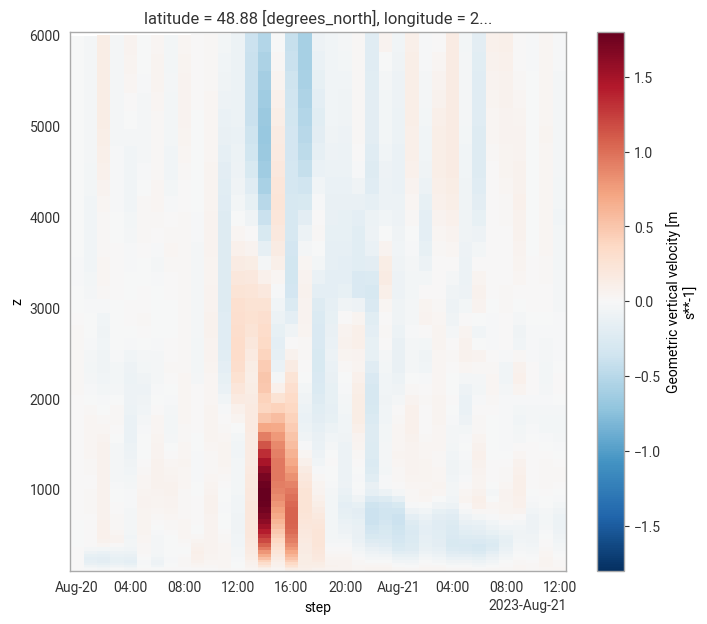

In [124]:
new.plot.pcolormesh(x="step",y="z")